- from Mel0719B1__B0SZ224
- no old data

# start

In [2]:
class Param: pass
param = Param()

#########################
param.PRFX = 'Mel0722A1'#
#########################

param.PRFX_B4 = None; param.FLD2USE_B4 = 0
param.ARCH = 'efficientnet-b0'

param.SZ = 224 
param.PRFX_PREP = 'MelPrp0909A224' 

param.EPOCHS = 10

param.BS = 40
param.SEED = 101; 

param.K=5; 
param.FLDS2USE = range(param.K)
param.FP16 = True
param.PLTFACTOR=0.5; param.PATIENCE=5; param.MIN_LR=1e-8

param.RandomResizedCrop_scale=(0.75, 1.0)
param.N_TTA = 20

param.LR=1e-3
param.WD=0

param.N_SAMPL = None

param.DEBUG = False
if param.DEBUG: 
    param.N_TTA = 2
    param.EPOCHS = 2
    param.FLDS2USE = [0,1]
    param.N_SAMPL = 1024

DEVICE = 'cuda'; 
if DEVICE=='cpu': param.FP16 = False
PIN_MEM = (DEVICE=='cuda'); N_WORKERS=4

param.__dict__

{'PRFX': 'Mel0722A1',
 'PRFX_B4': None,
 'FLD2USE_B4': 0,
 'ARCH': 'efficientnet-b0',
 'SZ': 224,
 'PRFX_PREP': 'MelPrp0909A224',
 'EPOCHS': 10,
 'BS': 40,
 'SEED': 101,
 'K': 5,
 'FLDS2USE': range(0, 5),
 'FP16': True,
 'PLTFACTOR': 0.5,
 'PATIENCE': 5,
 'MIN_LR': 1e-08,
 'RandomResizedCrop_scale': (0.75, 1.0),
 'N_TTA': 20,
 'LR': 0.001,
 'WD': 0,
 'N_SAMPL': None,
 'DEBUG': False}

In [3]:
!nvidia-smi

Wed Jul 22 12:41:44 2020       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 440.100      Driver Version: 440.100      CUDA Version: 10.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|===============================+======================+======================|
|   0  Tesla V100-SXM2...  Off  | 00000000:00:1E.0 Off |                    0 |
| N/A   42C    P0    42W / 300W |      0MiB / 16160MiB |      0%      Default |
+-------------------------------+----------------------+----------------------+
                                                                               
+-----------------------------------------------------------------------------+
| Processes:                                                       GPU Memory |
|  GPU  

# setup

In [4]:
from pathlib import Path
import pickle
import pandas as pd
import numpy as np
import random
import os, sys, gc
import datetime
from collections import defaultdict, Counter
import matplotlib.pyplot as plt
from PIL import Image
from tqdm import tqdm
from sklearn.model_selection import GroupKFold
from sklearn.metrics import roc_auc_score as roc_auc

# https://github.com/eriklindernoren/PyTorch-YOLOv3/issues/162#issuecomment-491115265
from PIL import ImageFile; ImageFile.LOAD_TRUNCATED_IMAGES = True

def dtnow(): return datetime.datetime.now().strftime('%Y-%m-%d %H:%M:%S')

import torch
device=torch.device(DEVICE)
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
import torchvision.transforms as transforms
import torch.optim as optim
from torch.optim import lr_scheduler

import pretrainedmodels
from efficientnet_pytorch import EfficientNet
import cv2
import albumentations as A
from albumentations import pytorch as AT

from apex import amp

import warnings; warnings.filterwarnings("ignore")


def sigmoid(x): return 1 / (1 + np.exp(-x))

def set_seed(seed):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True
set_seed(param.SEED)



p_out = f'../output/{param.PRFX}'; Path(p_out).mkdir(exist_ok=True,parents=True)
p_cmp = '../input/siim-isic-melanoma-classification'
if param.PRFX_B4 is not None: p_b4  = f'../output/{param.PRFX_B4}'


# prep

In [5]:
p_prp = f'../output/{param.PRFX_PREP}'
dftrn = pd.read_csv(f'{p_prp}/train_all_dedup.csv') 


dftrn = dftrn[dftrn.source==20]


print(dftrn.shape)

set_seed(param.SEED); dftrn = dftrn.sample(frac=1.)

if param.N_SAMPL is not None: dftrn = dftrn.head(param.N_SAMPL)
    
display(dftrn.head(2))
display(dftrn.shape)
display(dftrn.source.value_counts())
display(dftrn.groupby('source').target.mean())

(32701, 4)


,source,im_pth,patient_id,target
3464,20,../output/MelPrp0909A224/siim-isic-melanoma-cl...,IP_4879325,0.0
30075,20,../output/MelPrp0909A224/siim-isic-melanoma-cl...,IP_1866634,0.0


(32701, 4)

20    32701
Name: source, dtype: int64

source
20    0.017767
Name: target, dtype: float64

## folds

In [6]:
idx_nopid=np.where(dftrn.patient_id.isna())[0]
print(len(idx_nopid))
dftrn['patient_id'].iloc[idx_nopid]=[f'Nan_{i}' for i in range(len(idx_nopid))]
assert dftrn.patient_id.isna().mean()==0

0


In [7]:
set_seed(param.SEED)
kf = GroupKFold(n_splits=param.K)
fld2trvl=list(kf.split(dftrn, groups=dftrn.patient_id))

for fld, (tr, vl) in enumerate(fld2trvl):
    print(fld, len(tr), len(vl))
    dftr=dftrn.iloc[tr]
    dfvl=dftrn.iloc[vl]
    assert set(dftr.patient_id)&set(dfvl.patient_id)==set()
for fld, (tr, vl) in enumerate(fld2trvl):
    dftr=dftrn.iloc[tr]
    display(dftr.target.value_counts()/len(tr))
for fld, (tr, vl) in enumerate(fld2trvl):
    dftr=dftrn.iloc[tr]
    display(dftr.source.value_counts())

0 26161 6540
1 26161 6540
2 26161 6540
3 26161 6540
4 26160 6541


0.0    0.981461
1.0    0.018539
Name: target, dtype: float64

0.0    0.98192
1.0    0.01808
Name: target, dtype: float64

0.0    0.982761
1.0    0.017239
Name: target, dtype: float64

0.0    0.981881
1.0    0.018119
Name: target, dtype: float64

0.0    0.983142
1.0    0.016858
Name: target, dtype: float64

20    26161
Name: source, dtype: int64

20    26161
Name: source, dtype: int64

20    26161
Name: source, dtype: int64

20    26161
Name: source, dtype: int64

20    26160
Name: source, dtype: int64

In [8]:
display(dftrn.source.value_counts())
idx20 = np.where(dftrn.source==20)[0]
len(idx20)

20    32701
Name: source, dtype: int64

32701

In [9]:
fld2vl20 = []
for tr, vl in fld2trvl:
    vl20 = np.array([o for o in vl if o in idx20])
    print(len(vl), len(vl20))
    fld2vl20.append(vl20)

6540 6540
6540 6540
6540 6540
6540 6540
6541 6541


## testset

In [10]:
dftst = pd.read_csv(f'{p_prp}/test.csv', nrows=128 if param.DEBUG else None) 
display(dftst.head(3))

dfsub = pd.read_csv(f'{p_cmp}/sample_submission.csv', nrows=128 if param.DEBUG else None) 

,image_name,patient_id,sex,age_approx,anatom_site_general_challenge,im_pth
0,ISIC_0052060,IP_3579794,male,70.0,NaN,../output/MelPrp0909A224/siim-isic-melanoma-cl...
1,ISIC_0052349,IP_7782715,male,40.0,lower extremity,../output/MelPrp0909A224/siim-isic-melanoma-cl...
2,ISIC_0058510,IP_7960270,female,55.0,torso,../output/MelPrp0909A224/siim-isic-melanoma-cl...


# dataset

In [11]:
class MelDataset(Dataset):
    def __init__(self, df, mode='trn'):
        self.df = df
        self.mode = mode
        if self.mode == 'val':
            self.composed = A.Compose([
                A.Resize(param.SZ,param.SZ),
                A.Normalize(), 
                AT.ToTensor(),
            ]) 
        else:
            self.composed = A.Compose([
                A.RandomResizedCrop(param.SZ,param.SZ, scale=param.RandomResizedCrop_scale),
                A.Transpose(),
                A.Flip(),
                A.Rotate(360),
                A.OneOf([A.RandomBrightnessContrast(), A.CLAHE(),]),
                A.HueSaturationValue(hue_shift_limit=3, sat_shift_limit=3),
                A.OneOf([A.Blur(blur_limit=2), A.IAASharpen()]),
                A.Normalize(), 
                AT.ToTensor(),
            ])    
    def __getitem__(self, i):
        x = cv2.imread(self.df.im_pth.values[i]) 
        x = cv2.cvtColor(x, cv2.COLOR_BGR2RGB)
        x = self.composed(image=x)['image']
        if self.mode =='trn':
            y = self.df.target.values[i]
            return x, y
        else:
            return (x,)
    
    def __len__(self):
        return len(self.df)    

In [12]:
if param.DEBUG: 
    dstst = MelDataset(dftst, mode='tst')
    i = np.random.choice(len(dstst))
    print(dstst[i][0].shape)


In [13]:
# better comment out A.Normalize() when showing 
if param.DEBUG:
    plt.imshow(dstst[i][0].permute(1, 2, 0))

## test ds

In [14]:
dstst = MelDataset(dftst, mode='tst')
print(len(dstst))
dltst = DataLoader(dstst, batch_size=param.BS*2, shuffle=False, num_workers=N_WORKERS, pin_memory=PIN_MEM)
print(len(dltst))
lendl=len(dltst)

10982
138


# model

In [15]:
def mkmdl():  
    mdl = EfficientNet.from_pretrained(param.ARCH, num_classes=1)
    return mdl

In [16]:
mdl = mkmdl()

Loaded pretrained weights for efficientnet-b0


## focal loss

In [17]:
class FocalLoss(nn.Module):
    def __init__(self, alpha=1., gamma=3, logits=True, reduce=True):
        super(FocalLoss, self).__init__()
        self.alpha = alpha
        self.gamma = gamma
        self.logits = logits
        self.reduce = reduce

    def forward(self, inputs, targets):
        if self.logits:
            BCE_loss = F.binary_cross_entropy_with_logits(inputs, targets, reduce=False)
        else:
            BCE_loss = F.binary_cross_entropy(inputs, targets, reduce=False)
        pt = torch.exp(-BCE_loss)
        F_loss = self.alpha * (1-pt)**self.gamma * BCE_loss

        if self.reduce:
            return torch.mean(F_loss)
        else:
            return F_loss

def loss_fn(outputs, targets):
    return FocalLoss()(outputs, targets.view(-1, 1))

# train

## TTA

In [18]:
# def evaluate(model, dl):
#     model.eval()
#     prd = []
#     y = []
#     for step, dat in enumerate(dl):
#         xb, yb = (o.to(device) for o in dat)
#         with torch.no_grad(): prdb = model(xb)
#         prd.append(prdb.cpu().detach().numpy())
#         y.append(yb.cpu().detach().numpy())
#     prd = np.concatenate(prd)    
#     y = np.concatenate(y)    
#     lss = F.binary_cross_entropy_with_logits(torch.tensor(prd),torch.tensor(y).unsqueeze(1)).item()
#     scr = roc_auc(y, prd)
#     return lss, scr, y, prd

In [19]:
def evaluate(model, dl):
    model.eval()
    prd=[]
    y=[]
    for step, dat in enumerate(dl):
        xb, yb = (o.to(device) for o in dat)
        with torch.no_grad(): prdb = model(xb)
        prd.append(prdb.cpu().detach().numpy())
        y.append(yb.cpu().detach().numpy())
    prd = np.concatenate(prd)    
    y = np.concatenate(y)    
    lss = F.binary_cross_entropy_with_logits(torch.tensor(prd),torch.tensor(y).unsqueeze(1)).item()
    scr = roc_auc(y, prd)
    return lss, scr, y, prd

## infer

In [20]:
def infer(model, dl):
    model.eval()
    prd=[]
    for i in range(param.N_TTA):
        prdi = []
        for step, dat in enumerate(dl):
            xb=dat[0].to(device)
            with torch.no_grad(): 
                prdb = model(xb)
            prdi.append(prdb.cpu().detach().numpy())
        prdi = np.concatenate(prdi)    
        prd.append(prdi)
    prd = np.mean(prd, 0)
    return prd

## set up data

In [21]:
def getdls(fld):
    tr,vl=fld2trvl[fld]
    dftr=dftrn.iloc[tr]
    dfvl=dftrn.iloc[vl]
    ystr=dftr.target.values
    ysvl=dfvl.target.values
    dstr = MelDataset(dftr, mode='trn')
    dsvl = MelDataset(dfvl, mode='trn')
    dltr = DataLoader(dstr, batch_size=param.BS,       shuffle=True,  num_workers=N_WORKERS, pin_memory=PIN_MEM)
    dlvl = DataLoader(dsvl, batch_size=param.BS*2,     shuffle=False, num_workers=N_WORKERS, pin_memory=PIN_MEM)
    return dltr,dlvl

## run train

In [22]:
set_seed(param.SEED)

results = {}
results['fld2trvl'] = fld2trvl
results['param'] = param
results['fld2stats']={}

for fld in param.FLDS2USE:
    
    tr,vl=fld2trvl[fld]
    dltr,dlvl=getdls(fld)
    print(f'fld:{fld};', 'dltr,dlvl:', len(dltr), len(dlvl))

    mdl = mkmdl().to(device)
    if param.PRFX_B4 is not None: 
        fnm_mdl_b4 = f'{p_b4}/model_{param.PRFX_B4}_fld_{param.fld}_best.p'
        print('load previously trained', fnm_mdl_b4)
        mdl.load_state_dict(torch.load(fnm_mdl_b4, map_location=torch.device(DEVICE)))
    # opt = optim.SGD(mdl.parameters(), lr=param.LR, momentum=param.MOMENTUM, weight_decay=param.WD)
    opt = optim.Adam(mdl.parameters(), lr=param.LR, weight_decay=param.WD)
#     schdl = optim.lr_scheduler.ReduceLROnPlateau(opt, mode='max', factor=param.PLTFACTOR, patience=param.PATIENCE, min_lr=param.MIN_LR, verbose=True)
    schdl = optim.lr_scheduler.OneCycleLR(opt, max_lr=param.LR, total_steps=param.EPOCHS*len(dltr))
    if param.FP16: mdl, opt = amp.initialize(mdl, opt, opt_level='O1', verbosity=0)
    mdl.zero_grad()

        

    stats = {
    'lss': {'tr':[],'vl':[],},
    'scr': {'tr':[],'vl':[],},
    }
    ep2oof = []

    best_scr = float('-inf')
    best_epc = -1    
    
    for epc in range(param.EPOCHS):
        prdtr_ep=[]
        ytr_ep=[]
        for step, dat in enumerate(dltr):
            mdl.train()
            xb,yb=(o.to(device) for o in dat)
            yb = yb.unsqueeze(1)
            prdb = mdl(xb)
    #         loss = F.binary_cross_entropy_with_logits(prdb, yb)
            loss =  loss_fn(prdb,yb)
            if param.FP16:
                with amp.scale_loss(loss, opt) as scaled_loss:
                    scaled_loss.backward()
            else:
                loss.backward()
            if param.FP16:
                torch.nn.utils.clip_grad_norm_(amp.master_params(opt), 1)
            else:
                torch.nn.utils.clip_grad_norm_(mdl.parameters(), 1)
            opt.step()
            opt.zero_grad()
            prdtr_ep.append(prdb.cpu().detach().numpy())
            ytr_ep.append(yb.cpu().detach().numpy())
            if step>0 and step%1000==0: print(dtnow(), f'ep {epc} step {step}/{len(dltr)}')

        prdtr_ep = np.concatenate(prdtr_ep)
        ytr_ep = np.concatenate(ytr_ep)    
        lss_tr_ep = F.binary_cross_entropy_with_logits(torch.tensor(prdtr_ep),torch.tensor(ytr_ep)).item()
        scr_tr_ep = roc_auc(ytr_ep, prdtr_ep)
        stats['lss']['tr'].append(lss_tr_ep)
        stats['scr']['tr'].append(scr_tr_ep)

        lss_vl_ep, scr_vl_ep, yvl_ep, prdvl_ep = evaluate(mdl, dlvl)
        stats['lss']['vl'].append(lss_vl_ep)
        stats['scr']['vl'].append(scr_vl_ep)
        ep2oof.append(prdvl_ep)

        print(dtnow(), f'fld {fld} ep {epc}: lss_tr {lss_tr_ep:.3f}; lss_vl {lss_vl_ep:.3f}; scr_tr {scr_tr_ep:.3f}; scr_vl {scr_vl_ep:.3f}; ')

        if epc>=3 and (scr_vl_ep>best_scr or epc>=param.EPOCHS-3):
            prdtst = infer(mdl, dltst)
            dfsub.target = sigmoid(prdtst)
            dfsub.to_csv(f'{p_out}/submission_{param.PRFX}_fld_{fld}_epc_{epc}.csv', index=False)
            torch.save(mdl.state_dict(), f'{p_out}/model_{param.PRFX}_fld_{fld}_epc_{epc}.p')

        if scr_vl_ep>best_scr:
            print(f'better scr {best_scr:.3f} -> {scr_vl_ep:.3f}')
            best_scr = scr_vl_ep
            best_epc = epc
            if epc>=3: 
                torch.save(mdl.state_dict(), f'{p_out}/model_{param.PRFX}_fld_{fld}_best.p')
                dfsub.to_csv(f'{p_out}/submission_{param.PRFX}_fld_{fld}_best.csv', index=False)

        schdl.step(scr_vl_ep)  # Update learning rate schedule
        
        stats['best_scr'] = best_scr
        stats['best_epc'] = best_epc
        results['fld2stats'][fld] = stats
        pickle.dump(results, open(f'{p_out}/results_{param.PRFX}.p', 'wb'))  
    pickle.dump(ep2oof, open(f'{p_out}/ep2oof_{param.PRFX}_fld_{fld}.p', 'wb'))  

fld:0; dltr,dlvl: 655 82
Loaded pretrained weights for efficientnet-b0
2020-07-22 12:45:47 fld 0 ep 0: lss_tr 0.312; lss_vl 0.265; scr_tr 0.695; scr_vl 0.806; 
better scr -inf -> 0.806
2020-07-22 12:48:10 fld 0 ep 1: lss_tr 0.257; lss_vl 0.242; scr_tr 0.819; scr_vl 0.832; 
better scr 0.806 -> 0.832
2020-07-22 12:50:33 fld 0 ep 2: lss_tr 0.244; lss_vl 0.238; scr_tr 0.853; scr_vl 0.853; 
better scr 0.832 -> 0.853
2020-07-22 12:52:55 fld 0 ep 3: lss_tr 0.235; lss_vl 0.224; scr_tr 0.873; scr_vl 0.838; 
2020-07-22 12:55:16 fld 0 ep 4: lss_tr 0.227; lss_vl 0.238; scr_tr 0.871; scr_vl 0.873; 
better scr 0.853 -> 0.873
2020-07-22 13:02:50 fld 0 ep 5: lss_tr 0.222; lss_vl 0.208; scr_tr 0.894; scr_vl 0.868; 
2020-07-22 13:05:12 fld 0 ep 6: lss_tr 0.215; lss_vl 0.213; scr_tr 0.903; scr_vl 0.856; 
2020-07-22 13:07:33 fld 0 ep 7: lss_tr 0.209; lss_vl 0.210; scr_tr 0.912; scr_vl 0.873; 
better scr 0.873 -> 0.873
2020-07-22 13:15:06 fld 0 ep 8: lss_tr 0.199; lss_vl 0.216; scr_tr 0.922; scr_vl 0.872; 

In [23]:
pickle.dump(results, open(f'{p_out}/results_{param.PRFX}.p', 'wb'))  

# training trajec

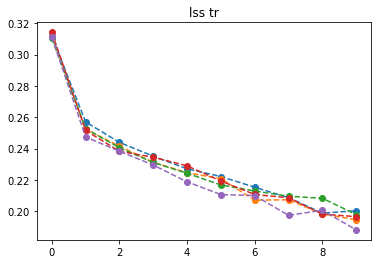

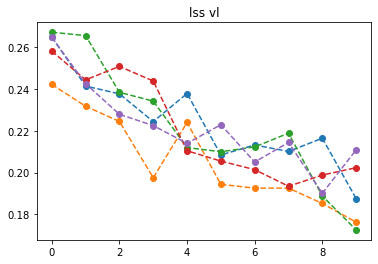

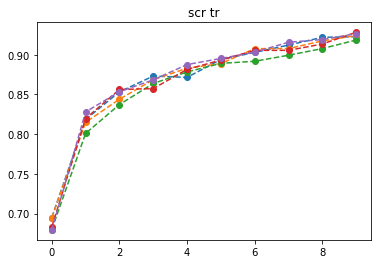

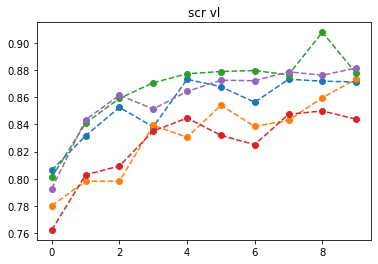

In [24]:
for mtrc in ['lss', 'scr']:
    for k in ['tr','vl',]:
        plt.title(f'{mtrc} {k}')
        for fld in param.FLDS2USE:
            plt.plot(results['fld2stats'][fld][mtrc][k], 'o--')
        plt.show()

# oofs

In [25]:
vls = []
for fld in param.FLDS2USE:
    _,vl=fld2trvl[fld]
    vls += list(vl)
len(vls), vls[:10]

(32701, [13, 24, 28, 38, 46, 48, 55, 64, 65, 71])

## only last epoch 

In [26]:
oofs = []
for fld in param.FLDS2USE:
    ep2oof = pickle.load(open(f'{p_out}/ep2oof_{param.PRFX}_fld_{fld}.p', 'rb'))
    ep2oof = np.concatenate(ep2oof,1)
    oof = list(ep2oof[:,-1])
    oofs += list(oof)
    
roc_auc(dftrn.target.iloc[vls], oofs)

0.869394246618211

In [27]:
oof_sorted = np.array([o[1] for o in sorted(zip(vls,oofs))])
roc_auc(dftrn.target.iloc[idx20], oof_sorted[idx20])

0.869394246618211

## only best_scr epoch

In [28]:
oofs = []
for fld in param.FLDS2USE:
    ep2oof = pickle.load(open(f'{p_out}/ep2oof_{param.PRFX}_fld_{fld}.p', 'rb'))
    ep2oof = np.concatenate(ep2oof,1)
    best_epc = results['fld2stats'][fld]['best_epc']
    oof = list(ep2oof[:,best_epc])
    oofs += list(oof)
roc_auc(dftrn.target.iloc[vls], oofs)

0.8773570710524004

In [29]:
oof_sorted = np.array([o[1] for o in sorted(zip(vls,oofs))])
roc_auc(dftrn.target.iloc[idx20], oof_sorted[idx20])

0.8773570710524004

## avg all epochs

In [30]:
oofs = []
for fld in param.FLDS2USE:
    ep2oof = pickle.load(open(f'{p_out}/ep2oof_{param.PRFX}_fld_{fld}.p', 'rb'))
    ep2oof = np.concatenate(ep2oof,1)
    oof = list(ep2oof.mean(1))
    oofs += list(oof)
roc_auc(dftrn.target.iloc[vls], oofs)

0.888519466587217

In [31]:
oof_sorted = np.array([o[1] for o in sorted(zip(vls,oofs))])
roc_auc(dftrn.target.iloc[idx20], oof_sorted[idx20])

0.888519466587217

## avg last m epochs

In [32]:
oofs = []
for fld in param.FLDS2USE:
    ep2oof = pickle.load(open(f'{p_out}/ep2oof_{param.PRFX}_fld_{fld}.p', 'rb'))
    ep2oof = np.concatenate(ep2oof,1)
    oof = list(ep2oof[:, -3:].mean(1))
    oofs += list(oof)
roc_auc(dftrn.target.iloc[vls], oofs)

0.8896540618978316

In [33]:
oof_sorted = np.array([o[1] for o in sorted(zip(vls,oofs))])
roc_auc(dftrn.target.iloc[idx20], oof_sorted[idx20])

0.8896540618978316

In [34]:
def get_oof_avg_last_m(m):
    oofs = []
    for fld in param.FLDS2USE:
        ep2oof = pickle.load(open(f'{p_out}/ep2oof_{param.PRFX}_fld_{fld}.p', 'rb'))
        ep2oof = np.concatenate(ep2oof,1)
        oof = list(ep2oof[:, -m:].mean(1))
        oofs += list(oof)
    return oofs

In [35]:
for m in range(1, 3):
    oofs = get_oof_avg_last_m(m)
    oof_sorted = np.array([o[1] for o in sorted(zip(vls,oofs))])
    print(m, f'{roc_auc(dftrn.target.iloc[vls], oofs):.3f}', 
          f'{roc_auc(dftrn.target.iloc[idx20], oof_sorted[idx20]):.3f}')


1 0.869 0.869
2 0.886 0.886


# submissions

## only last epoch

In [36]:
lst_sub = []
for fld in param.FLDS2USE:
    sub_fld = pd.read_csv(f'{p_out}/submission_{param.PRFX}_fld_{fld}_epc_{param.EPOCHS-1}.csv') 
    print('fld', fld, sub_fld.target.mean())
    display(sub_fld.head(3))
    lst_sub.append(sub_fld.target.values)

fld 0 0.16256515626079038


,image_name,target
0,ISIC_0052060,0.067630
1,ISIC_0052349,0.100697
2,ISIC_0058510,0.059439


fld 1 0.15527741196658149


,image_name,target
0,ISIC_0052060,0.082979
1,ISIC_0052349,0.066855
2,ISIC_0058510,0.065273


fld 2 0.14961567663057707


,image_name,target
0,ISIC_0052060,0.049857
1,ISIC_0052349,0.052060
2,ISIC_0058510,0.069782


fld 3 0.1731647317611539


,image_name,target
0,ISIC_0052060,0.105045
1,ISIC_0052349,0.072335
2,ISIC_0058510,0.060007


fld 4 0.18421131960207687


,image_name,target
0,ISIC_0052060,0.080459
1,ISIC_0052349,0.092393
2,ISIC_0058510,0.043374


0.16496685924423599


,image_name,target
0,ISIC_0052060,0.077194
1,ISIC_0052349,0.076868
2,ISIC_0058510,0.059575


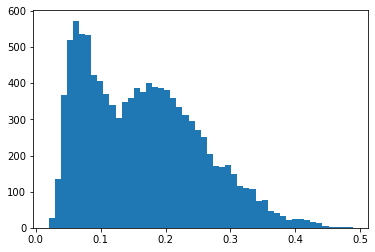

In [37]:
sub = np.mean(lst_sub,0)
print(sub.mean())
dfsub.target = sub
display(dfsub.head(3))
plt.hist(dfsub.target, bins=50);

In [38]:
dfsub.to_csv(f'{p_out}/submission_{param.PRFX}_onlylast.csv', index=False)

## only best_scr epoch

In [39]:
lst_sub = []
for fld in param.FLDS2USE:
    sub_fld = pd.read_csv(f'{p_out}/submission_{param.PRFX}_fld_{fld}_best.csv') 
    print('fld', fld, sub_fld.target.mean())
    display(sub_fld.head(3))
    lst_sub.append(sub_fld.target.values)

fld 0 0.1823292796925887


,image_name,target
0,ISIC_0052060,0.111730
1,ISIC_0052349,0.106616
2,ISIC_0058510,0.078487


fld 1 0.15527741196658149


,image_name,target
0,ISIC_0052060,0.082979
1,ISIC_0052349,0.066855
2,ISIC_0058510,0.065273


fld 2 0.16602347628492095


,image_name,target
0,ISIC_0052060,0.074494
1,ISIC_0052349,0.074446
2,ISIC_0058510,0.075711


fld 3 0.17366144835421654


,image_name,target
0,ISIC_0052060,0.142909
1,ISIC_0052349,0.075605
2,ISIC_0058510,0.037299


fld 4 0.18421131960207687


,image_name,target
0,ISIC_0052060,0.080459
1,ISIC_0052349,0.092393
2,ISIC_0058510,0.043374


0.1723005871800765


,image_name,target
0,ISIC_0052060,0.098514
1,ISIC_0052349,0.083183
2,ISIC_0058510,0.060029


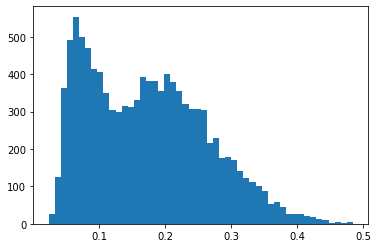

In [40]:
sub = np.mean(lst_sub,0)
print(sub.mean())
dfsub.target = sub
display(dfsub.head(3))
plt.hist(dfsub.target, bins=50);

In [41]:
dfsub.to_csv(f'{p_out}/submission_{param.PRFX}_onlybestscr.csv', index=False)

## avg last m epochs

In [42]:
m = 3

In [43]:
lst_sub = []
for fld in param.FLDS2USE:
    for epc in range(param.EPOCHS-m, param.EPOCHS):
        sub_fld = pd.read_csv(f'{p_out}/submission_{param.PRFX}_fld_{fld}_epc_{epc}.csv') 
        print('fld', fld, 'epc', epc, sub_fld.target.mean())
        display(sub_fld.head(3))
        lst_sub.append(sub_fld.target.values)

fld 0 epc 7 0.1823292796925887


,image_name,target
0,ISIC_0052060,0.111730
1,ISIC_0052349,0.106616
2,ISIC_0058510,0.078487


fld 0 epc 8 0.1843714520758056


,image_name,target
0,ISIC_0052060,0.048921
1,ISIC_0052349,0.085244
2,ISIC_0058510,0.076108


fld 0 epc 9 0.16256515626079038


,image_name,target
0,ISIC_0052060,0.067630
1,ISIC_0052349,0.100697
2,ISIC_0058510,0.059439


fld 1 epc 7 0.17172397153933697


,image_name,target
0,ISIC_0052060,0.123381
1,ISIC_0052349,0.069855
2,ISIC_0058510,0.061661


fld 1 epc 8 0.16522242018357278


,image_name,target
0,ISIC_0052060,0.126450
1,ISIC_0052349,0.089391
2,ISIC_0058510,0.071387


fld 1 epc 9 0.15527741196658149


,image_name,target
0,ISIC_0052060,0.082979
1,ISIC_0052349,0.066855
2,ISIC_0058510,0.065273


fld 2 epc 7 0.18907401008719282


,image_name,target
0,ISIC_0052060,0.129601
1,ISIC_0052349,0.128323
2,ISIC_0058510,0.088603


fld 2 epc 8 0.16602347628492095


,image_name,target
0,ISIC_0052060,0.074494
1,ISIC_0052349,0.074446
2,ISIC_0058510,0.075711


fld 2 epc 9 0.14961567663057707


,image_name,target
0,ISIC_0052060,0.049857
1,ISIC_0052349,0.052060
2,ISIC_0058510,0.069782


fld 3 epc 7 0.16691644447705378


,image_name,target
0,ISIC_0052060,0.111024
1,ISIC_0052349,0.074473
2,ISIC_0058510,0.048672


fld 3 epc 8 0.17366144835421654


,image_name,target
0,ISIC_0052060,0.142909
1,ISIC_0052349,0.075605
2,ISIC_0058510,0.037299


fld 3 epc 9 0.1731647317611539


,image_name,target
0,ISIC_0052060,0.105045
1,ISIC_0052349,0.072335
2,ISIC_0058510,0.060007


fld 4 epc 7 0.19190204784624798


,image_name,target
0,ISIC_0052060,0.089054
1,ISIC_0052349,0.072932
2,ISIC_0058510,0.077396


fld 4 epc 8 0.1680734307048975


,image_name,target
0,ISIC_0052060,0.091301
1,ISIC_0052349,0.085145
2,ISIC_0058510,0.039613


fld 4 epc 9 0.18421131960207687


,image_name,target
0,ISIC_0052060,0.080459
1,ISIC_0052349,0.092393
2,ISIC_0058510,0.043374


0.1722754851644676


,image_name,target
0,ISIC_0052060,0.095656
1,ISIC_0052349,0.083091
2,ISIC_0058510,0.063521


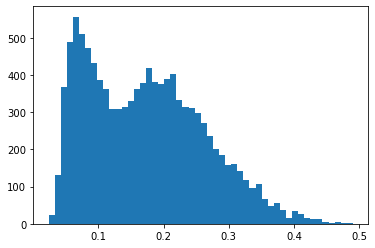

In [44]:
sub = np.mean(lst_sub,0)
print(sub.mean())
dfsub.target = sub
display(dfsub.head(3))
plt.hist(dfsub.target, bins=50);

In [45]:
dfsub.to_csv(f'{p_out}/submission_{param.PRFX}_avglast{m}.csv', index=False)

In [46]:
for m in [2, 3,]:
    print('m',m)
    lst_sub = []
    for fld in param.FLDS2USE:
        for epc in range(param.EPOCHS-m, param.EPOCHS):
            sub_fld = pd.read_csv(f'{p_out}/submission_{param.PRFX}_fld_{fld}_epc_{epc}.csv') 
            lst_sub.append(sub_fld.target.values)

    sub = np.mean(lst_sub,0)
    print(sub.mean())
    dfsub.target = sub

    dfsub.to_csv(f'{p_out}/submission_{param.PRFX}_avglast{m}.csv', index=False)

m 2
0.16821865238245948
m 3
0.1722754851644676


# fin

In [47]:
param.__dict__

{'PRFX': 'Mel0722A1',
 'PRFX_B4': None,
 'FLD2USE_B4': 0,
 'ARCH': 'efficientnet-b0',
 'SZ': 224,
 'PRFX_PREP': 'MelPrp0909A224',
 'EPOCHS': 10,
 'BS': 40,
 'SEED': 101,
 'K': 5,
 'FLDS2USE': range(0, 5),
 'FP16': True,
 'PLTFACTOR': 0.5,
 'PATIENCE': 5,
 'MIN_LR': 1e-08,
 'RandomResizedCrop_scale': (0.75, 1.0),
 'N_TTA': 20,
 'LR': 0.001,
 'WD': 0,
 'N_SAMPL': None,
 'DEBUG': False}

In [48]:
!nvidia-smi

Wed Jul 22 17:36:50 2020       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 440.100      Driver Version: 440.100      CUDA Version: 10.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|===============================+======================+======================|
|   0  Tesla V100-SXM2...  Off  | 00000000:00:1E.0 Off |                    0 |
| N/A   51C    P0    45W / 300W |   3948MiB / 16160MiB |      0%      Default |
+-------------------------------+----------------------+----------------------+
                                                                               
+-----------------------------------------------------------------------------+
| Processes:                                                       GPU Memory |
|  GPU  